In [1]:
import numpy as np
import pandas as pd
import gzip
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

Load the raw data and join them together

In [2]:
category = pd.read_csv('item_categories.csv')
category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [3]:
with gzip.open('sales_train.csv.gz', 'rb') as f:
    sales = pd.read_csv(f)

sales = sales[sales['item_id']<=1000]
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
587,07.01.2013,0,25,1000,99.00,1.00
588,16.01.2013,0,25,1000,99.00,1.00
612,19.01.2013,0,25,999,99.00,1.00
613,07.01.2013,0,25,999,99.00,1.00
614,26.01.2013,0,25,998,99.00,2.00


In [4]:
shops = pd.read_csv('shops.csv')

In [5]:
items = pd.read_csv('items.csv')

In [6]:
with gzip.open('test.csv.gz', 'rb') as f:
    test = pd.read_csv(f)

test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(category, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
587,07.01.2013,0,25,1000,99.00,1.00,"3D Action Puzzle ""Зомби"" Уборщик",67,"Москва ТРК ""Атриум""",Подарки - Развитие
588,16.01.2013,0,25,1000,99.00,1.00,"3D Action Puzzle ""Зомби"" Уборщик",67,"Москва ТРК ""Атриум""",Подарки - Развитие
612,19.01.2013,0,25,999,99.00,1.00,"3D Action Puzzle ""Зомби"" Пешеход",67,"Москва ТРК ""Атриум""",Подарки - Развитие
613,07.01.2013,0,25,999,99.00,1.00,"3D Action Puzzle ""Зомби"" Пешеход",67,"Москва ТРК ""Атриум""",Подарки - Развитие
614,26.01.2013,0,25,998,99.00,2.00,"3D Action Puzzle ""Зомби "" Железнодорожник",67,"Москва ТРК ""Атриум""",Подарки - Развитие


To reduce computation time, only train data that is in the test set

In [8]:
test_shop_id = test['shop_id'].unique()
test_item_id = test['item_id'].unique()
train = train[train['shop_id'].isin(test_shop_id)]
train = train[train['item_id'].isin(test_item_id)]
train.shape

(26581, 10)

In [9]:
# Select only useful features.
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
train_monthly.head()

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
626,29.01.2013,0,25,73,829,3300.00,1.00
627,10.01.2013,0,25,49,832,299.00,1.00
629,11.01.2013,0,25,49,832,299.00,1.00
630,16.01.2013,0,25,73,839,3300.00,1.00
631,21.01.2013,0,25,73,839,3300.00,1.00


In [10]:
#create features by grouping item_price and item_cnt_day
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum','mean'],'item_cnt_day':['sum', 'mean','count']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [11]:
#ensure every single item / shop group has a month from 0 - 33
empty = []

for shop in train_monthly['shop_id'].unique():
    for item in train_monthly['item_id'].unique():
        for i in range(34):
            empty.append([i,shop,item])
            
empty_df = pd.DataFrame(empty, columns = ['date_block_num','shop_id','item_id'])
train_monthly = pd.merge(empty_df,train_monthly, on =['date_block_num','shop_id','item_id'], how = 'left')
train_monthly = train_monthly.fillna(0)
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,33,37.00,499.00,499.00,1.00,1.00,1.00
1,1,2,33,0.00,0.00,0.00,0.00,0.00,0.00
2,2,2,33,0.00,0.00,0.00,0.00,0.00,0.00
3,3,2,33,0.00,0.00,0.00,0.00,0.00,0.00
4,4,2,33,0.00,0.00,0.00,0.00,0.00,0.00


In [12]:
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: (x//12)+ 2013)
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x%12))
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,33,37.00,499.00,499.00,1.00,1.00,1.00,2013,0
1,1,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,1
2,2,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,2
3,3,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,3
4,4,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,4


In [13]:
#remove outliers
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

In [14]:
#creating the y target - 'item_cnt_month'
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_cnt'].shift(-1)
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month
0,0,2,33,37.00,499.00,499.00,1.00,1.00,1.00,2013,0,0.00
1,1,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,1,0.00
2,2,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,2,0.00
3,3,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,3,0.00
4,4,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,4,0.00


In [15]:
#creating a new column called item_price)unit
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit
0,0,2,33,37.00,499.00,499.00,1.00,1.00,1.00,2013,0,0.00,499.00
1,1,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,1,0.00,0.00
2,2,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,2,0.00,0.00
3,3,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,3,0.00,0.00
4,4,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,4,0.00,0.00


In [16]:
#finding the features with grouping item_id to find price max and min
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':['min','max']})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on = 'item_id', how = 'left')

train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease
0,0,2,33,37.00,499.00,499.00,1.00,1.00,1.00,2013,0,0.00,499.00,0.00,2994.00,499.00,2495.00
1,1,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,1,0.00,0.00,0.00,2994.00,0.00,2994.00
2,2,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,2,0.00,0.00,0.00,2994.00,0.00,2994.00
3,3,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,3,0.00,0.00,0.00,2994.00,0.00,2994.00
4,4,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,4,0.00,0.00,0.00,2994.00,0.00,2994.00


In [17]:
#add features on the previous trends with the rolling function
f_min = lambda x: x.rolling(window = 3, min_periods = 1).min()
f_max = lambda x: x.rolling(window = 3, min_periods = 1).max()
f_mean = lambda x: x.rolling(window = 3, min_periods = 1).mean()
f_std = lambda x: x.rolling(window = 3, min_periods = 1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

train_monthly['item_cnt_std'].fillna(0, inplace = True)
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,2,33,37.00,499.00,499.00,1.00,1.00,1.00,2013,...,0.00,499.00,0.00,2994.00,499.00,2495.00,1.00,1.00,1.00,0.00
1,1,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,0.00,0.00,2994.00,0.00,2994.00,0.00,0.00,0.00,0.00
2,2,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,0.00,0.00,2994.00,0.00,2994.00,0.00,0.00,0.00,0.00
3,3,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,0.00,0.00,2994.00,0.00,2994.00,0.00,0.00,0.00,0.00
4,4,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,0.00,0.00,2994.00,0.00,2994.00,0.00,0.00,0.00,0.00


In [18]:
#add features of the previous 3 months 
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

train_monthly['item_trend'] = (train_monthly['item_cnt'] - train_monthly['item_cnt_shifted1'] - train_monthly['item_cnt_shifted2'] - train_monthly['item_cnt_shifted3']) / 4

train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,2,33,37.00,499.00,499.00,1.00,1.00,1.00,2013,...,499.00,2495.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.25
1,1,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,2994.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,2994.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,2994.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,4,2,33,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,2994.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [19]:
#split the data into train, validate and test
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 161615
Validation set records: 32323
Test set records: 6465
Train set records: 161615 (74% of complete data)
Validation set records: 32323 (15% of complete data)


In [20]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [21]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [22]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [23]:
test = test[test['item_id']<=1000]

latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]
X_test.head()

,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,5,560,0.00,0.00,0.00,0.00,0.00,0.00,2015,9,...,0.00,0.00,0.00,0.00,0.00,0.05,0.13,0.04,0.11,0.12
1,5,562,0.00,0.00,0.00,0.00,0.00,0.00,2015,9,...,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.11,0.12
2,5,839,0.00,0.00,0.00,0.00,0.00,0.00,2015,9,...,0.00,0.00,0.00,0.00,0.00,0.05,0.66,0.20,0.11,0.12
3,5,978,0.00,0.00,0.00,0.00,0.00,0.00,2015,9,...,0.00,0.00,0.00,0.00,0.00,0.05,0.10,0.00,0.11,0.12
4,5,982,0.00,0.00,0.00,0.00,0.00,0.00,2015,9,...,0.00,0.00,0.00,0.00,0.00,0.05,0.17,0.08,0.11,0.12


In [24]:
#fill in missing values
sets = [X_train, X_validation, X_test]
          
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [25]:
# I'm dropping "item_category_id"
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [26]:
X_train.head()

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,2.00,33.00,0.00,0.00,0.00,0.00,0.00,2013.00,3.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.04,0.49,0.32,0.11,0.10
1,2.00,33.00,0.00,0.00,0.00,0.00,0.00,2013.00,4.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.04,0.49,0.32,0.11,0.15
2,2.00,33.00,0.00,0.00,0.00,0.00,0.00,2013.00,5.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.04,0.49,0.32,0.11,0.15
3,2.00,33.00,0.00,0.00,0.00,0.00,0.00,2013.00,6.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.04,0.49,0.32,0.11,0.12
4,2.00,33.00,0.00,0.00,0.00,0.00,0.00,2013.00,7.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.04,0.49,0.32,0.11,0.11


In [27]:
# cat_features are the index to the categorical variables in the x_train
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

0:	learn: 0.6812893	test: 0.6321283	best: 0.6321283 (0)	total: 198ms	remaining: 1m 38s
50:	learn: 0.4629556	test: 0.4442865	best: 0.4442865 (50)	total: 5.5s	remaining: 48.5s
100:	learn: 0.4349725	test: 0.4268425	best: 0.4268425 (100)	total: 11.2s	remaining: 44.1s
150:	learn: 0.4282563	test: 0.4243511	best: 0.4242441 (132)	total: 16.8s	remaining: 38.9s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.4242440869
bestIteration = 132

Shrink model to first 133 iterations.


Dataset is provided, but PredictionValuesChange feature importance don't use it, since non-empty LeafWeights in model.


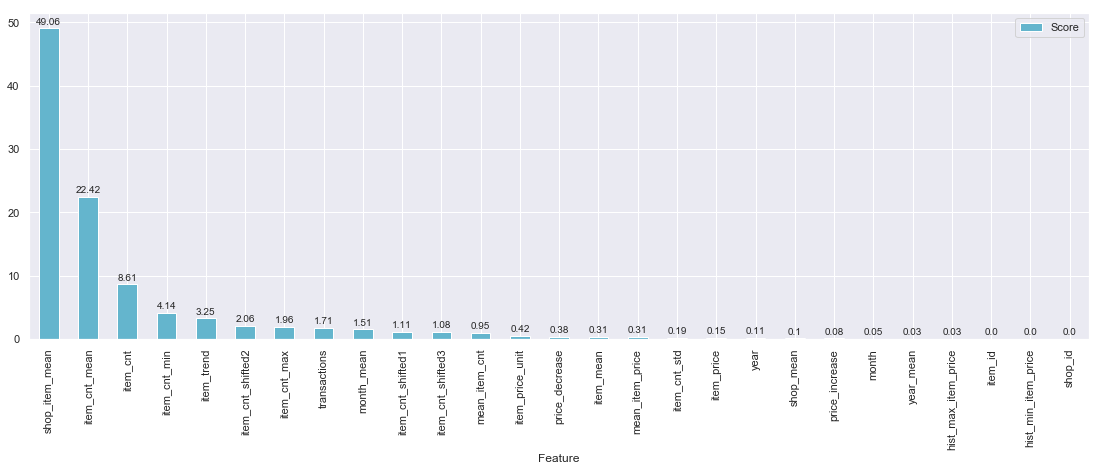

In [28]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
for p in ax.patches:
    height = p.get_height()
    label = p.get_height().round(2)
    ax.text(p.get_x() + p.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

[0]	validation_0-rmse:0.740588	validation_1-rmse:0.706413
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.501874	validation_1-rmse:0.480928
[40]	validation_0-rmse:0.490079	validation_1-rmse:0.472143
[60]	validation_0-rmse:0.486357	validation_1-rmse:0.468431
[80]	validation_0-rmse:0.48391	validation_1-rmse:0.465183
[100]	validation_0-rmse:0.481825	validation_1-rmse:0.464467
[120]	validation_0-rmse:0.479805	validation_1-rmse:0.462116
[140]	validation_0-rmse:0.478272	validation_1-rmse:0.461572
[160]	validation_0-rmse:0.476787	validation_1-rmse:0.461345
[180]	validation_0-rmse:0.47569	validation_1-rmse:0.46085
[200]	validation_0-rmse:0.474376	validation_1-rmse:0.45967
[220]	validation_0-rmse:0.473476	validation_1-rmse:0.459831
[240]	validation_0-rmse:0.472414	validation_1-rmse:0.45816
[260]	validation_0-rmse:0.471714	validation_1-rmse:0.45757
[280]	validat

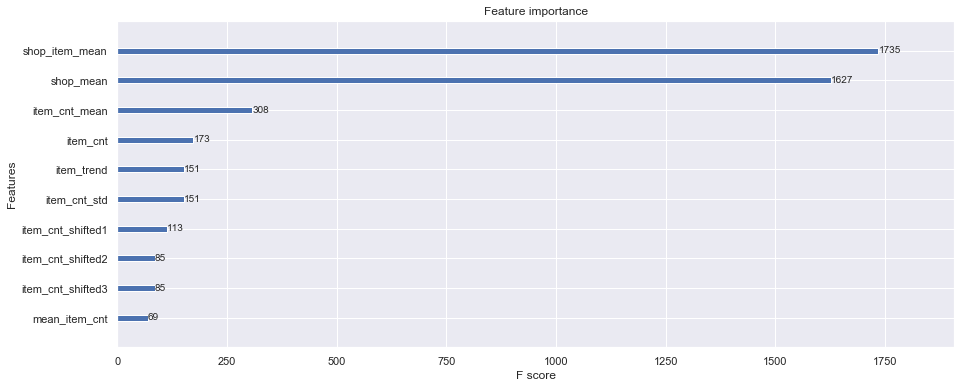

In [29]:
#xgboost
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

#create the model
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

#create the feature importance plot
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [30]:
#random forest
# Use only part of features on random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']

rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [31]:
#create a dataframe to store the predicted results
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['label'] = Y_validation.values
first_level.head()

,catboost,xgbm,random_forest,label
0,0.42,0.42,0.35,0
1,0.24,0.26,0.17,1
2,0.40,0.42,0.35,0
3,0.22,0.26,0.17,1
4,0.41,0.42,0.35,0


In [32]:
#create a second level linear regression, using validation data to train this linear regression, 
#then the predict the test for all 34 sales forecast
first_level = first_level.drop('label', axis = 1)

meta_model = LinearRegression(n_jobs=-1)
meta_model.fit(first_level,Y_validation)
score = meta_model.score(first_level,Y_validation)
score

0.5913965578399738